In [158]:
# import libraries
import numpy as np
import random

# Section 1

## Question 6
Below we will use the numpy library to calculate the eigenvalues and eigenvectors for the 
graph laplacian we calculated earlier numerically

In [2]:
# calculate the eigenvalues and eigenvectors
L = np.array([
    [2, -1, -1, 0, 0],
    [-1, 2, -1, 0, 0],
    [-1, -1, 2, 0, 0],
    [0, 0, 0, 1, -1],
    [0, 0, 0, -1, 1]
])

eigenvalues, eigenvectors = np.linalg.eig(L)

idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


In [3]:
# print results
print("Eigenvalues:", eigenvalues)


Eigenvalues: [-4.4408921e-16  0.0000000e+00  2.0000000e+00  3.0000000e+00
  3.0000000e+00]


In [4]:
print("Eigenvectors:\n", eigenvectors)

Eigenvectors:
 [[-0.57735027  0.          0.          0.81649658  0.29329423]
 [-0.57735027  0.          0.         -0.40824829 -0.80655913]
 [-0.57735027  0.          0.         -0.40824829  0.5132649 ]
 [ 0.          0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.70710678 -0.70710678  0.          0.        ]]


The first two eigenvalues are ~ 0 and correspond to the connected components. The corresponding first two eigenvectors highlight that the first three nodes 1 to 3 belong to a single component and the nodes 4 and 5 belong to another component. 

# Section 3


In [98]:
# import libraries
import cv2
import matplotlib.pyplot as plt
import time
import os

In [25]:
# we will use assistance to convert images to the necessary format
def pixel_image(path):
    # cv2 uses BGR format for pizel color representation, not RGB
    image_pixels = cv2.imread(path)
    
    # we will use matplotlib to visualize later so lets get our data from BGR to RGB format
    image_rgb = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2RGB) 
    # print(image_pixels.shape)
    pixels = image_rgb.reshape(-1, 3)
    
    return pixels, image_rgb

In [40]:
# create the pixel input representation for the three images
football = pixel_image('./data/football.bmp')[0]
coastal = pixel_image('./data/coastal-abstract.jpeg')[0]
greycat = pixel_image('./data/256px-Greycat.jpg')[0]

In [87]:
# test your distance formula implementations on a mini matrix
mini_matrix = football[0:3]
print(mini_matrix)

centroids= [[75,82,85], [73, 81, 80]]

print(centroids)

print(mini_matrix[:, np.newaxis] - centroids)

print((mini_matrix[:, np.newaxis] - centroids)**2)

print(((mini_matrix[:, np.newaxis] - centroids)**2).sum(axis=2))

print(np.argmin(((mini_matrix[:, np.newaxis] - centroids)**2).sum(axis=2), axis=1))

print(np.linalg.norm(mini_matrix[:, np.newaxis] - centroids, axis=2)**2)

print(np.argmin(np.linalg.norm(mini_matrix[:, np.newaxis] - centroids, axis=2)**2, axis = 1))


[[76 84 87]
 [73 81 84]
 [68 76 79]]
[[75, 82, 85], [73, 81, 80]]
[[[ 1  2  2]
  [ 3  3  7]]

 [[-2 -1 -1]
  [ 0  0  4]]

 [[-7 -6 -6]
  [-5 -5 -1]]]
[[[ 1  4  4]
  [ 9  9 49]]

 [[ 4  1  1]
  [ 0  0 16]]

 [[49 36 36]
  [25 25  1]]]
[[  9  67]
 [  6  16]
 [121  51]]
[0 0 1]
[[  9.  67.]
 [  6.  16.]
 [121.  51.]]
[0 0 1]


In [159]:
# set up your number of clusters k
k_list = [2,4,8,16,32]

# set my random seed for reproducibility
np.random.seed(123)
random.seed(123)

In [82]:
'''
Create the k-means function
Input: matrix of pixels, value for k
Output: a matrix with an assigned cluster for each pixel, a matrix of k centroids with BGR values for each,
a matrix of initialzed centroid values based on random initialization, the number of iterations to converge, total time to converge for each
'''
def k_means(matrix, k):
    
    # start the timer
    num_iterations = 0
    start_time = time.time()
    
    # randomly initialize k centroids: choosing full random instead of selecting from an existing centroid
    init_centroids = np.random.randint(0, 256, size = (k,3))
    
    # we're going to update our centroids but we also want to maintain our initial centroids to compare
    centroids = init_centroids.copy()
    updated_k = k
    
    # initialize the vector which will hold the cluster assignment for each pixel
    cluster_assignments = np.zeros(matrix.shape[0], dtype = int)
    # print(cluster_assignments)
    
    # we will continue the below until our condition of convergence is met
    
    while True:
        # assign each pixel to nearest centroid
        # for i in range(matrix.shape[0]):
        #     # use l2 norm squared or euclidian squared distance to assign
        #     distances = np.sum((matrix[i] - centroids)**2, axis = 1)
        #     cluster_assignments[i] = np.argmin(distances)
        
        # assign each pixel to nearest centroid: vectorized approach using numpy to speed things up
        # distances = ((matrix[:, np.newaxis] - centroids)**2).sum(axis=2)
        
        # trying with linalg.norm per suggestion on Ed
        distances = np.linalg.norm(matrix[:, np.newaxis] - centroids, axis=2)**2
        cluster_assignments = np.argmin(distances, axis=1)
        
        # now that assignment is complete, update the centroids using mean -> type int of pixel in that cluster
        updated_centroids = []
        
        for j in range(k):
            points_in_cluster = matrix[cluster_assignments == j]

            # per assignment, make sure to handle empty clusters through a random reassignment or deletion
            if len(points_in_cluster) > 0:
                # updated_centroids[j] = np.mean(points_in_cluster, axis = 0).astype(int)
                updated_centroids.append(np.mean(points_in_cluster, axis=0).astype(int))
            # else:
                # updated_centroids[j] = np.random.randint(0, 256, size=(3,))
        
        # let's go with the approach of dropping empty clusters per the assignment: maybe it will speed convergence
        updated_centroids = np.array(updated_centroids)
        
        updated_k = updated_centroids.shape[0]
        
        # check to see if current pixel assignments are the same as previous run, if so, end the loop
        if np.array_equal(updated_centroids, centroids):
            break
        
        # update necessary vars
        centroids = updated_centroids.copy()
        num_iterations += 1
    
    # end the timer
    end_time = time.time()
    
    time_elapsed = end_time - start_time
    
    # print(num_iterations, time_elapsed)
    
    return cluster_assignments, centroids, init_centroids, num_iterations, time_elapsed, updated_k

In [104]:
'''
 Write a function that takes in your outputs from the k-means function and returns original visual and 
 newly created visuals after running for given k 5 times (chosen arbitraily)
 Input: image
 Output: original image, print new images, print initialization centroids for each, number iterations to converge for each, and total time in seconds for each to converge
'''

def run_k_means_and_visualize(path, k_list):
    
    # get the matrix for the image passed in
    image_pixels, image_shape = pixel_image(path)
    
    # let's first display the original image to compare our renditions against
    plt.figure()
    plt.imshow(image_shape)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # run this for each value of k
    for k in k_list:
        
        # initialize the values we are going to print for the best iteration
        best_wcss = float('inf')
        best_iteration = None
        best_compressed_image = None
        best_init_centroids = None
        best_num_iterations = None
        best_time_elapsed = None
        best_updated_k = None
        
        # run this 5 times with diff rand initializations
        for iteration in range(5):
            
            # get the vals from our k_means function run
            cluster_assignments, centroids, init_centroids, num_iterations, time_elapsed, updated_k = k_means(image_pixels, k)
            
            # calculate the within-cluster sum of squares as our optimization metric
            # for each cluster, take the sum of the squared differences between each data point and the centroid
            # then sum up the total for te iteration
            wcss = sum(np.sum((image_pixels[cluster_assignments == j] - centroids[j]) ** 2) for j in range(updated_k))
            
            # make sure to update best wcss and other best_vars 
            if wcss < best_wcss:
                best_wcss = wcss
                best_iteration = iteration + 1
                best_compressed_pixels = centroids[cluster_assignments]
                best_compressed_image = best_compressed_pixels.reshape(image_shape.shape)
                best_init_centroids = init_centroids
                best_num_iterations = num_iterations
                best_time_elapsed = time_elapsed
                best_updated_k = updated_k
            
            
        # print the information desired for best iteration
        print(f"k = {k}, Best Iteration {best_iteration}:")
        print(f"Best Initialized Centroids:\n{best_init_centroids}")
        print(f"Number of Centroid Updates for Best Iteration: {best_num_iterations}")
        print(f"Total Time (seconds) for Best Iteration: {best_time_elapsed:.2f}")
        print(f"Num Clusters for Best Iteration: {best_updated_k}\n")
        
        
        
        
        plt.figure()
        plt.imshow(best_compressed_image)
        plt.title(f'k = {k}, num_clusters = {best_updated_k}, Iteration {best_iteration}')
        plt.axis('off')
        
        # save the image
        basename = os.path.basename(path)
        fname = os.path.splitext(basename)[0]
        save_path = os.path.join('./outputs/',f'{fname}_{k}.png')
        plt.savefig(save_path)
        
        # display the image
        plt.show()
        
        
        
    plt.close()

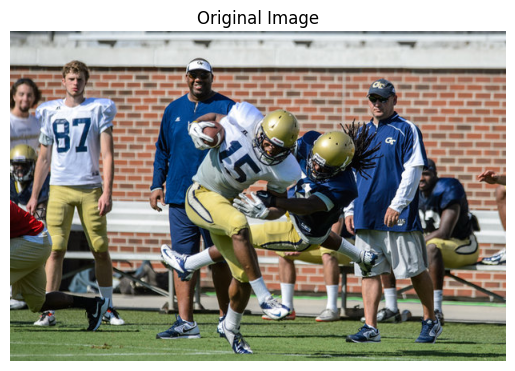

k = 2, Best Iteration 1:
Best Initialized Centroids:
[[175 143  13]
 [178 206 189]]
Number of Centroid Updates for Best Iteration: 7
Total Time (seconds) for Best Iteration: 0.36
Num Clusters for Best Iteration: 2



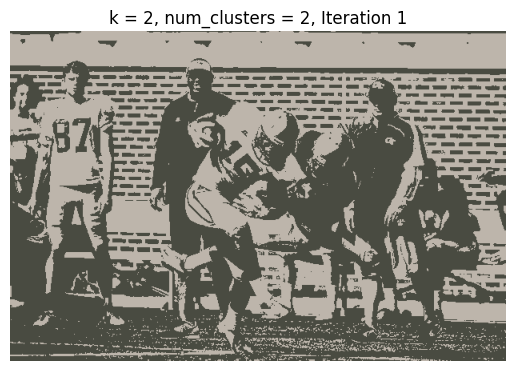

k = 4, Best Iteration 3:
Best Initialized Centroids:
[[232 143  98]
 [145 184  71]
 [ 63 210 235]
 [108 203 127]]
Number of Centroid Updates for Best Iteration: 12
Total Time (seconds) for Best Iteration: 0.85
Num Clusters for Best Iteration: 4



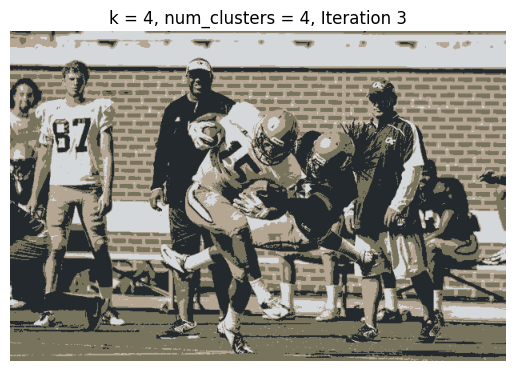

k = 8, Best Iteration 5:
Best Initialized Centroids:
[[ 89 139 141]
 [110 136  49]
 [ 93 118 208]
 [235 237 253]
 [ 86  46 145]
 [132  11  32]
 [215 101  25]
 [ 53 132   2]]
Number of Centroid Updates for Best Iteration: 15
Total Time (seconds) for Best Iteration: 1.91
Num Clusters for Best Iteration: 8



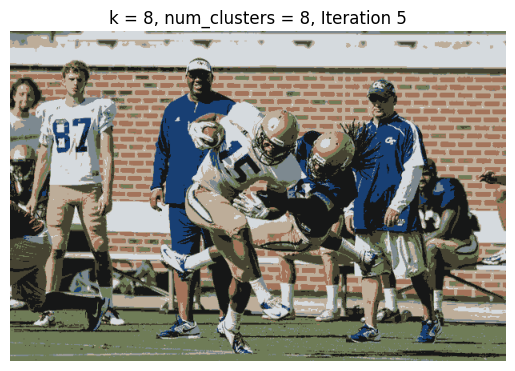

k = 16, Best Iteration 4:
Best Initialized Centroids:
[[186 157 112]
 [251 240 243]
 [164 234 252]
 [ 73  36 161]
 [189 241  24]
 [149 181 198]
 [ 52  93 127]
 [178  73 130]
 [ 80 163  73]
 [ 21 131 168]
 [  4  22  42]
 [193 127  77]
 [245  65 182]
 [ 39  28  55]
 [  7 207  27]
 [155 130 226]]
Number of Centroid Updates for Best Iteration: 26
Total Time (seconds) for Best Iteration: 5.27
Num Clusters for Best Iteration: 14



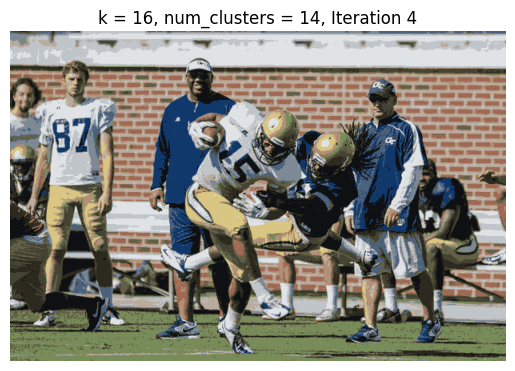

k = 32, Best Iteration 2:
Best Initialized Centroids:
[[ 11 208   9]
 [ 23  70  18]
 [109 165 233]
 [ 64 149  80]
 [164 100 177]
 [ 52 115  89]
 [108 163 102]
 [ 79   7 118]
 [138  97  21]
 [ 59  17  14]
 [145  51 110]
 [224 194 206]
 [ 80 123 228]
 [ 14 175 121]
 [145 117  27]
 [117  35 187]
 [ 19 169  18]
 [235   8 134]
 [ 27  49  75]
 [250 145 180]
 [237 105 110]
 [237 216 207]
 [158 166 252]
 [120 116  88]
 [135 226 212]
 [ 12 212  48]
 [ 85 103 197]
 [236 173  46]
 [ 20  69 168]
 [170  25   4]
 [ 38  32  39]
 [147 162 172]]
Number of Centroid Updates for Best Iteration: 42
Total Time (seconds) for Best Iteration: 15.15
Num Clusters for Best Iteration: 26



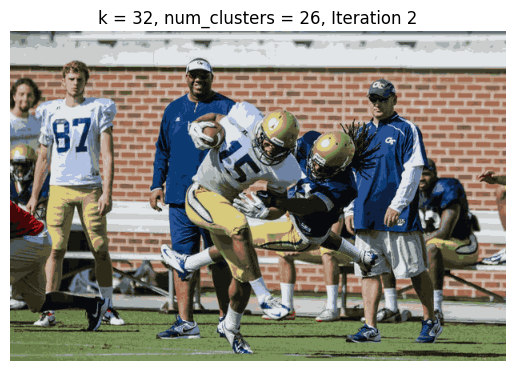

In [105]:
# football
run_k_means_and_visualize('./data/football.bmp', k_list)

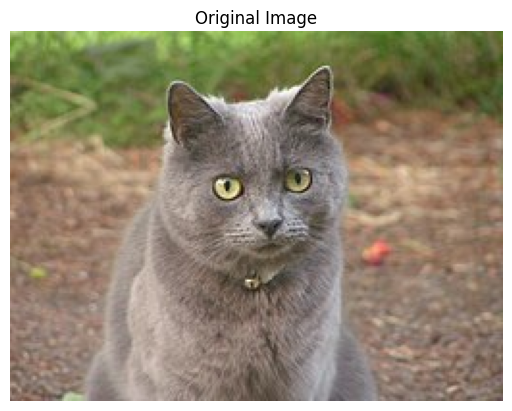

k = 2, Best Iteration 1:
Best Initialized Centroids:
[[ 16 125  53]
 [252 209  32]]
Number of Centroid Updates for Best Iteration: 10
Total Time (seconds) for Best Iteration: 0.08
Num Clusters for Best Iteration: 2



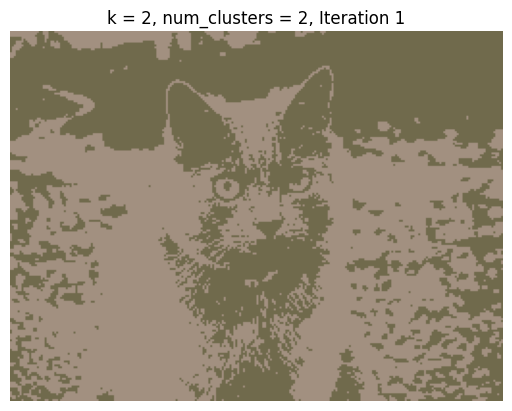

k = 4, Best Iteration 5:
Best Initialized Centroids:
[[169 176 242]
 [164  74  36]
 [223  83 119]
 [139 198 133]]
Number of Centroid Updates for Best Iteration: 21
Total Time (seconds) for Best Iteration: 0.66
Num Clusters for Best Iteration: 4



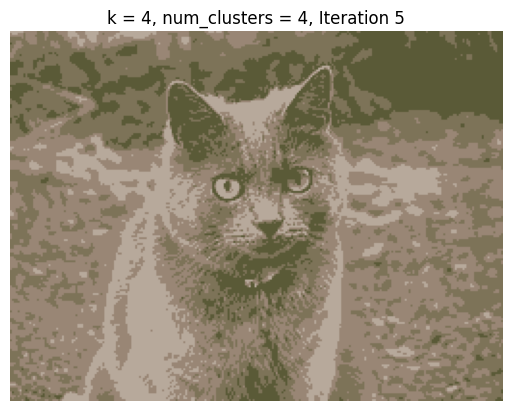

k = 8, Best Iteration 3:
Best Initialized Centroids:
[[212 166  62]
 [ 54 163  87]
 [198  87  19]
 [235   4 132]
 [180 241  79]
 [176 147  23]
 [107   3   4]
 [136 176  54]]
Number of Centroid Updates for Best Iteration: 25
Total Time (seconds) for Best Iteration: 0.50
Num Clusters for Best Iteration: 7



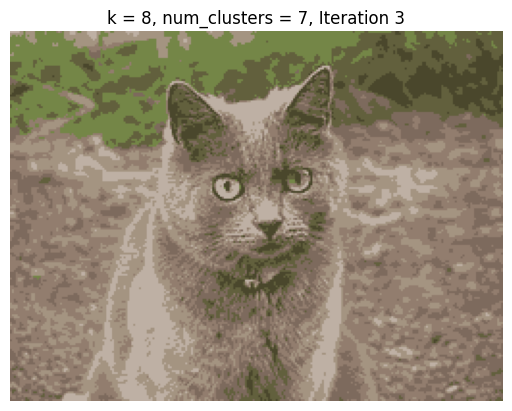

k = 16, Best Iteration 3:
Best Initialized Centroids:
[[ 58 182  64]
 [ 65 224 182]
 [210 175  83]
 [134 237  50]
 [187  93 191]
 [ 23 228 212]
 [225 109  56]
 [250 247  86]
 [249  19 133]
 [135  38  59]
 [ 14 110 199]
 [115 138 222]
 [ 46  25  78]
 [ 64  13 117]
 [110 223 152]
 [177 101 247]]
Number of Centroid Updates for Best Iteration: 62
Total Time (seconds) for Best Iteration: 1.93
Num Clusters for Best Iteration: 11



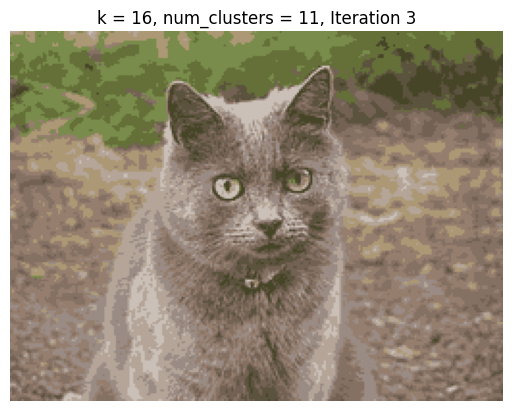

k = 32, Best Iteration 5:
Best Initialized Centroids:
[[175 214 223]
 [112  70  12]
 [ 81   9 214]
 [ 87 106  56]
 [195 213 246]
 [252 134 115]
 [236  71 110]
 [ 38  50 251]
 [ 94 144 146]
 [ 47 235 135]
 [219 245 251]
 [226 110  81]
 [ 26 116  32]
 [106   4  94]
 [215  91 197]
 [211 152 238]
 [ 52 158 213]
 [166   4 208]
 [173 129 102]
 [191 234  70]
 [151  43  50]
 [ 24  18   5]
 [215  16 231]
 [141 224 198]
 [ 19  80  74]
 [199 248 205]
 [162 147 161]
 [179 144 209]
 [ 97  91 210]
 [ 86 124  69]
 [  4  94  70]
 [135  61 190]]
Number of Centroid Updates for Best Iteration: 40
Total Time (seconds) for Best Iteration: 1.91
Num Clusters for Best Iteration: 17



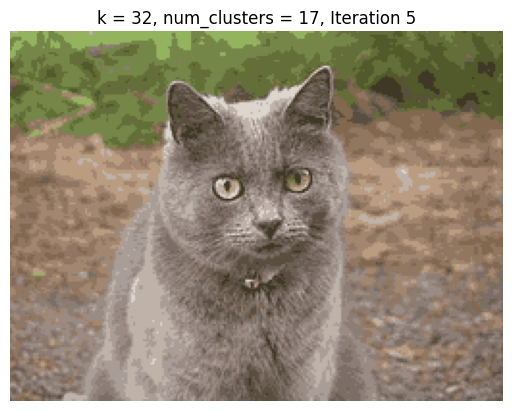

In [106]:
# cat (self chosen image)
run_k_means_and_visualize('./data/256px-Greycat.jpg', k_list)

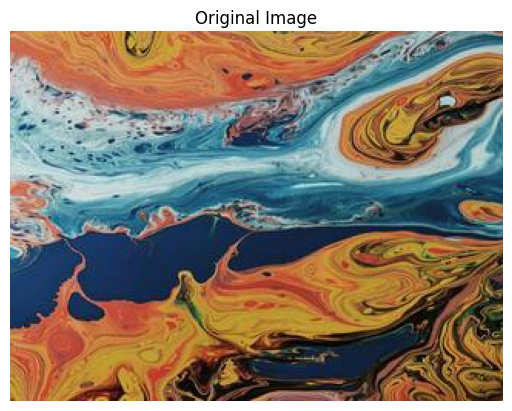

k = 2, Best Iteration 1:
Best Initialized Centroids:
[[132  97  51]
 [ 77 157 237]]
Number of Centroid Updates for Best Iteration: 15
Total Time (seconds) for Best Iteration: 0.18
Num Clusters for Best Iteration: 2



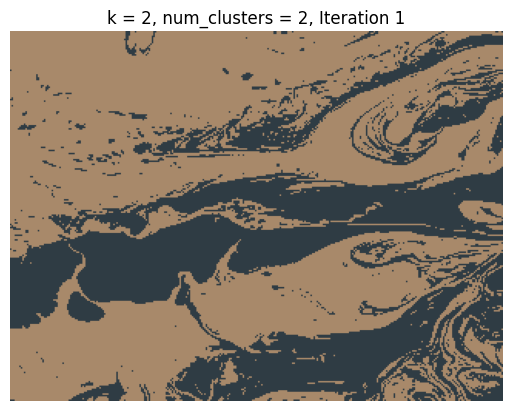

k = 4, Best Iteration 2:
Best Initialized Centroids:
[[ 71 131  31]
 [187  50  24]
 [135 220  75]
 [ 19 107 254]]
Number of Centroid Updates for Best Iteration: 8
Total Time (seconds) for Best Iteration: 0.16
Num Clusters for Best Iteration: 4



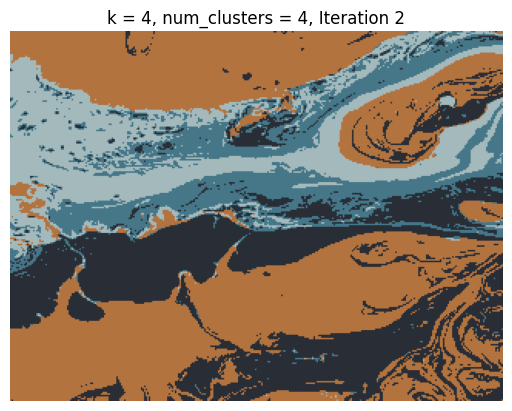

k = 8, Best Iteration 3:
Best Initialized Centroids:
[[243 153 189]
 [138 164  27]
 [230 130 176]
 [ 72 159 244]
 [144 161 246]
 [174 249 158]
 [ 98   8 193]
 [201 153 209]]
Number of Centroid Updates for Best Iteration: 38
Total Time (seconds) for Best Iteration: 1.37
Num Clusters for Best Iteration: 8



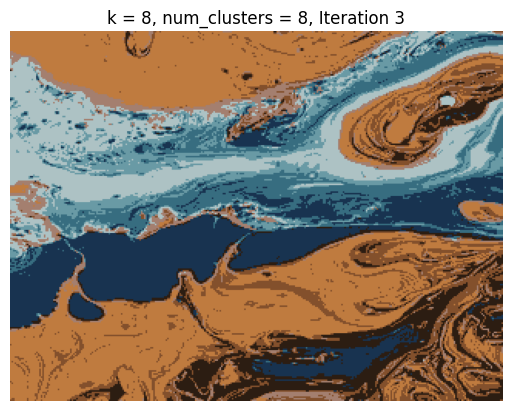

k = 16, Best Iteration 1:
Best Initialized Centroids:
[[122 238  38]
 [185  37 145]
 [216 224 235]
 [ 93 177 167]
 [ 74 246 197]
 [105 119  73]
 [194 185 173]
 [219 103  45]
 [ 98 193  16]
 [ 67 168 243]
 [122  58  98]
 [239  10  52]
 [127 162 133]
 [  2 168 114]
 [ 10  83  48]
 [ 69 188 140]]
Number of Centroid Updates for Best Iteration: 39
Total Time (seconds) for Best Iteration: 2.31
Num Clusters for Best Iteration: 13



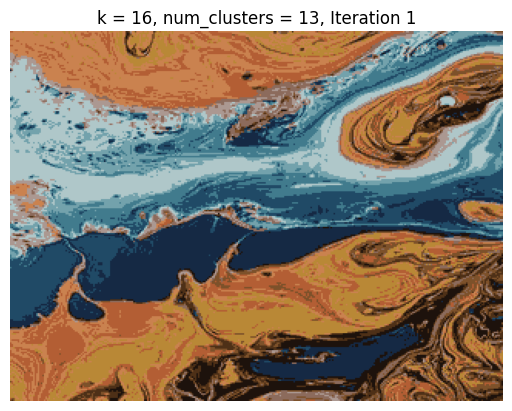

k = 32, Best Iteration 1:
Best Initialized Centroids:
[[149 120  18]
 [135 171 229]
 [219  59 206]
 [123  39 241]
 [189 123 154]
 [ 97 107  47]
 [224  44 176]
 [129  67 104]
 [170  15 162]
 [218  74  82]
 [ 80 110  82]
 [138  82 183]
 [177 139  32]
 [ 41  96 144]
 [149 237  97]
 [203  47 251]
 [159   4  78]
 [175 196  71]
 [126 106 107]
 [186  64 234]
 [ 11  16 121]
 [108   0  14]
 [193 149 154]
 [ 81 103  50]
 [ 82 176 215]
 [ 70 127  84]
 [ 46  30  91]
 [182  10  98]
 [242 173 146]
 [190 154 112]
 [ 74 171 153]
 [ 14  10  19]]
Number of Centroid Updates for Best Iteration: 42
Total Time (seconds) for Best Iteration: 4.55
Num Clusters for Best Iteration: 24



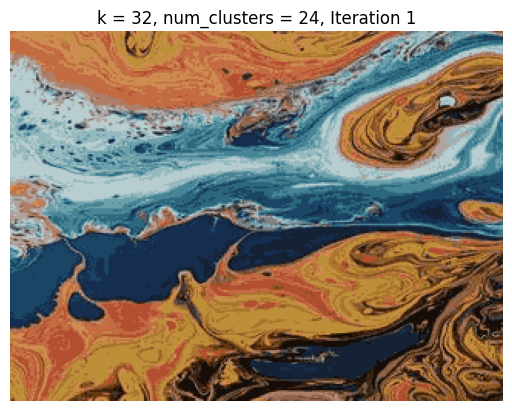

In [107]:
# coastal abstract
run_k_means_and_visualize('./data/coastal-abstract.jpeg', k_list)

# 4. MNIST Dataset Clustering

In [142]:
from pyclustering.cluster import encoder
# import libraries
from sklearn.cluster import KMeans

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import random_center_initializer, kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding, cluster_encoder
from pyclustering.utils import read_sample

from scipy.io import loadmat
import warnings
import numpy as np
np.warnings = warnings

In [143]:
# read in the file and standardize data per assignment req

def read_MNIST(path):
    data = loadmat(path)
    xtrain = data['xtrain'] / 255.0
    ytrain = data['ytrain'].flatten()
    
    return data, xtrain, ytrain

In [144]:
# test out and visualize the data
data, xtrain, ytrain = read_MNIST('./data/mnist_10digits.mat')


In [145]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Oct 13 20:00:03 2020',
 '__version__': '1.0',
 '__globals__': [],
 'xtrain': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'ytrain': array([[5, 0, 4, ..., 5, 6, 8]]),
 'xtest': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'ytest': array([[7, 2, 1, ..., 4, 5, 6]])}

In [146]:
xtrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [147]:
ytrain

array([5, 0, 4, ..., 5, 6, 8])

In [148]:
# set the number of clusters we want k = 10 and metrics
k = 10
# metric_names = ["Squared Euclidean", "Manhattan"]

In [149]:
'''
K Means 
input: k, mnist training, distance_type

ouput: a cluster value for each point
'''
def kmeans_run(k, xtrain, distance_type):
    
    # set the initial centroids, let's use kmeans++ instead of running n iterations of diff initializations
    initial_centers = kmeans_plusplus_initializer(xtrain, k).initialize()
    
    # set the metric we want to use
    if distance_type == 0:
        metric = distance_metric(type_metric.EUCLIDEAN_SQUARE)
    elif distance_type == 1:
        metric = distance_metric(type_metric.MANHATTAN)
    else:
        raise ValueError("Invalid distance type. Use 0 for squared Euclidean or 1 for Manhattan.")
        
    kmeans_instance = kmeans(xtrain, initial_centers, metric = metric)
    
    # Running into numpy warning issues, disabling for now.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kmeans_instance.process()
    
    # assign the clusters to each data point
    clusters = kmeans_instance.get_clusters()
    
    cluster_assignments = np.zeros(xtrain.shape[0], dtype=int)
    for cluster_id, cluster_points in enumerate(clusters):
        cluster_assignments[cluster_points] = cluster_id
        
    return cluster_assignments

In [150]:
'''
assign most common label to each cluster

input: cluster_assignments, ytrain (labels)
ouput: assigned_labels
'''
def assign_labels(cluster_assignments, ytrain):
    
    # if there's a possibility not all clusters were assigned data points
    k = np.unique(cluster_assignments).size
    
    # instantiate the assigned_labels array
    assigned_labels = np.zeros_like(ytrain)
    
    for cluster_id in range(k):
        cluster_points = np.where(cluster_assignments == cluster_id)[0]
        cluster_labels = ytrain[cluster_points]
        
        # find the most common label for each cluster
        most_common_label = np.bincount(cluster_labels).argmax()
        
        # assign the labels
        assigned_labels[cluster_points] = most_common_label
        
    return assigned_labels
        
        

In [155]:
'''
function to calculate purity score for each cluster as well as average purity score
input: assigned_labels, ytrain
output: purity_scores, average purity score
'''

def calculate_purity(assigned_labels, ytrain, cluster_assignments):
    
    k = np.unique(cluster_assignments).size
    purity_scores = []
    total_correct = 0
    
    # for each cluster get true and assigned labels and then calculate purity
    for cluster_id in range(k):
        cluster_points = np.where(cluster_assignments == cluster_id)[0]
        cluster_true_labels = ytrain[cluster_points]
        cluster_assigned_labels = assigned_labels[cluster_points]
        
        most_common_label = cluster_assigned_labels[0]
        
        correct_assignments = np.sum(cluster_true_labels == cluster_assigned_labels)
        cluster_purity = correct_assignments / len(cluster_points)
        purity_scores.append((int(cluster_id), int(most_common_label), round(float(cluster_purity),4)))
    
        total_correct += correct_assignments
    
    # Calculate the average purity across all clusters
    average_purity = round(total_correct / len(ytrain) , 4)
    
    return purity_scores, average_purity

In [152]:
# function that runs all the above and then prints out purity scores for both squared l2 norm and manhattan

def run_kmeans_and_purity(path, distance_type, k):
    
    # create the data
    data, xtrain, ytrain = read_MNIST(path)
    
    # run the kmeans function
    cluster_assignments = kmeans_run(k, xtrain, distance_type)
    
    # run the cluster label assignment function
    assigned_labels = assign_labels(cluster_assignments, ytrain)
    # run the purity function
    purity_scores, average_purity = calculate_purity(assigned_labels, ytrain, cluster_assignments)
    # return the purity outputs
    return distance_type, purity_scores, average_purity

In [156]:
# run for squared l2_norm and then manhattan
sl2_dist, sl2_purity_scores, sl2_avg_purity = run_kmeans_and_purity('./data/mnist_10digits.mat', 0, k)

man_dist, man_purity_scores, man_avg_purity = run_kmeans_and_purity('./data/mnist_10digits.mat', 1, k)

In [160]:
# print out purities for clusters: l2norm
print(sl2_dist)
print(sl2_purity_scores)
print(sl2_avg_purity)



0
[(0, 1, 0.5902), (1, 0, 0.9385), (2, 3, 0.531), (3, 5, 0.3058), (4, 6, 0.8723), (5, 1, 0.6471), (6, 4, 0.3585), (7, 8, 0.6194), (8, 2, 0.9177), (9, 7, 0.4367)]
0.5828


In [161]:
# l1norm: manhattan

print(man_dist)
print(man_purity_scores)
print(man_avg_purity)

1
[(0, 8, 0.5693), (1, 8, 0.4366), (2, 1, 0.3586), (3, 7, 0.3841), (4, 6, 0.8728), (5, 0, 0.941), (6, 3, 0.5966), (7, 2, 0.9603), (8, 4, 0.3948), (9, 0, 0.8901)]
0.5169
